# Introduction

TODO


# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding, Lambda, Concatenate, Reshape
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
from keras.models import load_model
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
import re
%matplotlib inline

Using TensorFlow backend.


# Utility functions

In [2]:
def gpu_alloc(device_id):
    os.environ["CUDA_VISIBLE_DEVICES"]=device_id
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc("1")

In [4]:
def build_chars_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0 # Start index for any char will be 1, as 0 is masked by the Embedding/Masking layer
    codes = ['UNK', ' ', '\t','\n']# Start 'UNK' at the first entry, to keep its index=0 to be masked
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1    
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1


    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [5]:
def vectorize_sentences_data(input_texts, target_labels, max_sents_per_doc, max_words_per_sent, max_chars_per_word, 
                             num_classes, char2int):

    
    hier_input_data_lst = []
    hier_target_data_lst = []

    if(target_labels == None):
        target_labels = np.zeros(len(input_texts), dtype='int32')
    
    for _, (input_text, target_label) in enumerate(zip(input_texts, target_labels)):
        hier_input_data = np.zeros((max_sents_per_doc, 
                                    max_words_per_sent, 
                                    max_chars_per_word), dtype='float32')


        hier_target_data = np.zeros(num_classes, dtype='float32')

        #sents_lst = sent_tokenize(clean_str(BeautifulSoup(input_text).get_text())) # TODO: Move to clean str
        sents_lst = sent_tokenize(input_text)
        
        
        if len(sents_lst) > max_sents_per_doc:
            continue
        j=0
        for _, sent in enumerate(sents_lst):
                
            words_lst = word_tokenize(input_text)
            
            if(len(words_lst) > max_words_per_sent):
                continue
            
            
            k=0
            for _, word in enumerate(words_lst):
                
                
                if(len(word) > max_chars_per_word):
                    continue
                
                
                l=0
                for l, char in enumerate(word):
                    # c0..cn
                    if(char in char2int):
                        hier_input_data[j, k, l] = char2int[char]
                        try:
                            hier_target_data[target_label] = 1
                        except:
                            print(target_label)
                        l=l+1
                k=k+1
            j=j+1
                            
        hier_input_data_lst.append(hier_input_data)
        hier_target_data_lst.append(hier_target_data)
                
    return np.array(hier_input_data_lst), np.array(hier_target_data_lst)

In [6]:
def build_chars2word_model_simple_BiLSTM(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None,), dtype='float32')
    
    encoder_inputs_ = Embedding(num_encoder_tokens, latent_dim,                                                       
                            mask_zero=True)(encoder_inputs)    
    '''
    print(encoder_inputs.shape)
    encoder_inputs_ = Embedding(num_encoder_tokens, num_encoder_tokens,                           
                            weights=[np.eye(num_encoder_tokens)],
                            mask_zero=True, trainable=False)(encoder_inputs)     
    '''
    #encoder_inputs = Input(shape=(None, num_encoder_tokens))
    print(encoder_inputs_.shape)
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
 
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    encoder_word_embedding_model = Model(input=encoder_inputs, output=encoder_embedding_output)

    return encoder_word_embedding_model

In [7]:
def build_words2sent_model_simple_BiLSTM(encoder_word_embedding_model, 
                           max_words_seq_len, 
                           max_char_seq_len, 
                           latent_dim):
    # Define an input sequence and process it.

    inputs = Input(shape=(max_words_seq_len, max_char_seq_len,), dtype='float32')
    #print(inputs.shape)
    input_words = TimeDistributed(encoder_word_embedding_model)(inputs)

    encoder_inputs_ = input_words   
    #encoder_inputs = Input(shape=(None, char_vocab_size))
    encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
        
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    encoder_sentence_embedding_model = Model(input=inputs, output=encoder_embedding_output)

    return encoder_sentence_embedding_model

In [8]:
 
def build_sent2doc_model(encoder_sentence_embedding_model, 
                         max_sents_seq_len, 
                         max_words_seq_len, 
                         max_char_seq_len, 
                         word2sent_latent_dim,
                         sent2doc_latent_dim):
    
    inputs = Input(shape=(max_sents_seq_len, max_words_seq_len, max_char_seq_len,), dtype='float32')
    
    sents_states = []
    
    for s in range(max_sents_seq_len):
        
        encoder_words_inputs = Lambda(lambda x: x[:,s,:,:])(inputs)
        #print(encoder_words_inputs.shape)
        encoder_words_outputs = encoder_sentence_embedding_model(encoder_words_inputs)
        encoder_words_outputs = Reshape((1,word2sent_latent_dim*2))(encoder_words_outputs)
        #_, h, c = encoder_sentence_embedding_model(encoder_words_inputs)
        '''
        input_words = TimeDistributed(encoder_word_embedding_model)(inputs)

        encoder_inputs_ = input_words   
        #encoder_inputs = Input(shape=(None, char_vocab_size))
        encoder = Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
        encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM

        encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
        '''
        
        
        #encoder_words_states = Concatenate()([h,c])
        #print(encoder_chars_states)
        #encoder_words_states = Reshape((1,word2sent_latent_dim*4))(encoder_words_states)
        #print(encoder_words_outputs.shape)
        sents_states.append(encoder_words_outputs)
    print(sents_states[0]._keras_shape)
    input_sents = Concatenate(axis=-2)(sents_states)
    #print(input_sents.shape)
    encoder_inputs_ = input_sents   
    encoder = Bidirectional(LSTM(sent2doc_latent_dim, return_state=True, return_sequences=True)) # Bi LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs_)# Bi LSTM
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM
    encoder_embedding_output = Lambda(lambda x: x[:,-1,:])(encoder_outputs)
    
    encoder_document_embedding_model = Model(input=inputs, output=encoder_embedding_output)
    '''
    preds = Dense(2, activation='softmax')(encoder_embedding_output)
    model = Model(inputs, preds)
    '''
    #return model, encoder_document_embedding_model
    return encoder_document_embedding_model

In [9]:
def build_hier_senti_model(encoder_document_embedding_model,
                           max_sents_seq_len, 
                           max_words_seq_len, 
                           max_char_seq_len):
    inputs = Input(shape=(max_sents_seq_len, max_words_seq_len, max_char_seq_len,), dtype='float32')
    encoder_embedding_output = encoder_document_embedding_model(inputs)
    preds = Dense(2, activation='softmax')(encoder_embedding_output)
    model = Model(inputs, preds)
    return model

In [10]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

# Data loading and analysis

## Load data

In [11]:
data_path = '../../dat/'


In [12]:
data_file = 'imdb/labeledTrainData.tsv'
data_train = pd.read_csv(os.path.join(data_path, data_file), sep='\t')
print(data_train.shape)
data_train.head()

(25000, 3)


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [13]:
#data_train = data_train[:1000]

In [14]:
data_file = 'imdb/testData.tsv'
data_test = pd.read_csv(os.path.join(data_path, data_file), sep='\t')
print(data_test.shape)
data_test.head()

(25000, 2)


,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [15]:
#data_test = data_test[:1000]

In [16]:
data_train.review

0        With all this stuff going down at the moment w...
1        \The Classic War of the Worlds\" by Timothy Hi...
2        The film starts with a manager (Nicholas Bell)...
3        It must be assumed that those who praised this...
4        Superbly trashy and wondrously unpretentious 8...
5        I dont know why people think this is such a ba...
6        This movie could have been very good, but come...
7        I watched this video at a friend's house. I'm ...
8        A friend of mine bought this film for £1, and ...
9        <br /><br />This movie is full of references. ...
10       What happens when an army of wetbacks, towelhe...
11       Although I generally do not like remakes belie...
12       \Mr. Harvey Lights a Candle\" is anchored by a...
13       I had a feeling that after \Submerged\", this ...
14       note to George Litman, and others: the Mystery...
15       Stephen King adaptation (scripted by King hims...
16       `The Matrix' was an exciting summer blockbuste.

In [17]:
all_texts = data_train.review  + data_test.review

### Histogram of lenghts

In [18]:
#import nltk
#nltk.download('punkt')

In [19]:

chars_per_words_lengths = []
words_per_sents_lengths = []
sents_per_docs_lengths = []

# Chars per word should be on all text

for text in all_texts:
    
    sents = sent_tokenize(clean_str(BeautifulSoup(text).get_text()))
    sents_per_docs_lengths.append(len(sents))
    for sent in sents:       
    
        words = word_tokenize(text)
        words_per_sents_lengths.append(len(words))
        for word in words:
            chars_per_words_lengths.append(len(word))

    

/opt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


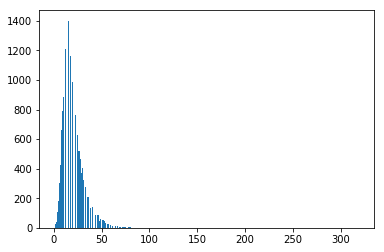

In [20]:
h_s = plt.hist(sents_per_docs_lengths, bins=500)

In [21]:
np.mean(sents_per_docs_lengths)

20.207560000000001

In [22]:
np.max(sents_per_docs_lengths)

319

In [23]:
np.std(sents_per_docs_lengths)

11.078223632261627

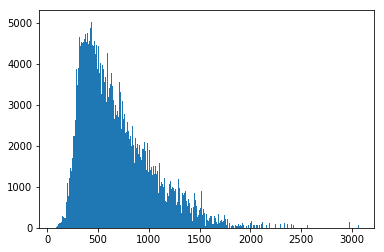

In [24]:
h_w = plt.hist(words_per_sents_lengths, bins=500)

In [25]:
np.mean(words_per_sents_lengths)

689.28778734295486

In [26]:
np.max(words_per_sents_lengths)

3067

In [27]:
np.std(words_per_sents_lengths)

360.16663872920708

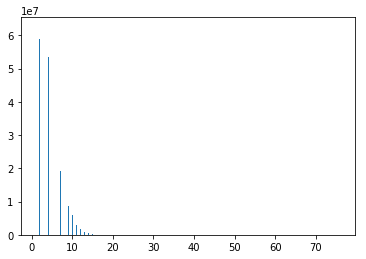

In [28]:
h_c = plt.hist(chars_per_words_lengths, bins=500)

In [29]:
np.mean(chars_per_words_lengths)

3.8747657059975036

In [30]:
np.max(chars_per_words_lengths)

76

In [31]:
np.std(chars_per_words_lengths)

2.5450141543538503

In [32]:
all_texts = list(all_texts.apply(BeautifulSoup).apply(BeautifulSoup.get_text).apply(clean_str))


/opt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [33]:
train_texts = list(data_train.review.apply(BeautifulSoup).apply(BeautifulSoup.get_text).apply(clean_str))
test_texts = list(data_test.review.apply(BeautifulSoup).apply(BeautifulSoup.get_text).apply(clean_str))

/opt/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /opt/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


## Build char vocab (all text)

In [34]:

vocab_to_int, int_to_vocab = build_chars_vocab(all_texts)
#np.savez('vocab_char-{}'.format(max_sent_len), vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )
char2int = vocab_to_int
int2char = int_to_vocab

In [35]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in all_texts])

In [36]:
print('Number of samples:', len(all_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)


Number of samples: 25000
Number of unique input tokens: 162
Number of unique output tokens: 162
Max sequence length for inputs: 14299


In [37]:
char2int

{'\t': 2,
 '\n': 3,
 ' ': 1,
 '!': 37,
 '#': 67,
 '$': 51,
 '%': 60,
 '&': 55,
 '(': 35,
 ')': 36,
 '*': 53,
 '+': 66,
 ',': 23,
 '-': 41,
 '.': 27,
 '/': 49,
 '0': 31,
 '1': 42,
 '2': 30,
 '3': 56,
 '4': 48,
 '5': 45,
 '6': 43,
 '7': 50,
 '8': 46,
 '9': 44,
 ':': 39,
 ';': 38,
 '<': 90,
 '=': 59,
 '>': 91,
 '?': 34,
 '@': 71,
 'UNK': 0,
 '[': 62,
 ']': 63,
 '^': 89,
 '_': 72,
 '`': 57,
 'a': 8,
 'b': 28,
 'c': 22,
 'd': 16,
 'e': 17,
 'f': 12,
 'g': 13,
 'h': 7,
 'i': 5,
 'j': 19,
 'k': 26,
 'l': 9,
 'm': 18,
 'n': 15,
 'o': 14,
 'p': 29,
 'q': 33,
 'r': 21,
 's': 10,
 't': 6,
 'u': 11,
 'v': 20,
 'w': 4,
 'x': 32,
 'y': 24,
 'z': 25,
 '{': 96,
 '|': 105,
 '}': 97,
 '~': 65,
 '\x80': 123,
 '\x84': 70,
 '\x85': 64,
 '\x8d': 134,
 '\x8e': 155,
 '\x91': 102,
 '\x95': 125,
 '\x96': 47,
 '\x97': 73,
 '\x9a': 159,
 '\x9e': 156,
 '\xa0': 148,
 '¡': 93,
 '¢': 133,
 '£': 52,
 '¤': 152,
 '¦': 118,
 '§': 153,
 '¨': 40,
 '©': 144,
 'ª': 145,
 '«': 130,
 '\xad': 150,
 '®': 83,
 '°': 146,
 '³': 149

In [38]:
int2char

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'w',
 5: 'i',
 6: 't',
 7: 'h',
 8: 'a',
 9: 'l',
 10: 's',
 11: 'u',
 12: 'f',
 13: 'g',
 14: 'o',
 15: 'n',
 16: 'd',
 17: 'e',
 18: 'm',
 19: 'j',
 20: 'v',
 21: 'r',
 22: 'c',
 23: ',',
 24: 'y',
 25: 'z',
 26: 'k',
 27: '.',
 28: 'b',
 29: 'p',
 30: '2',
 31: '0',
 32: 'x',
 33: 'q',
 34: '?',
 35: '(',
 36: ')',
 37: '!',
 38: ';',
 39: ':',
 40: '¨',
 41: '-',
 42: '1',
 43: '6',
 44: '9',
 45: '5',
 46: '8',
 47: '\x96',
 48: '4',
 49: '/',
 50: '7',
 51: '$',
 52: '£',
 53: '*',
 54: '´',
 55: '&',
 56: '3',
 57: '`',
 58: 'é',
 59: '=',
 60: '%',
 61: 'ê',
 62: '[',
 63: ']',
 64: '\x85',
 65: '~',
 66: '+',
 67: '#',
 68: 'è',
 69: 'ó',
 70: '\x84',
 71: '@',
 72: '_',
 73: '\x97',
 74: 'ı',
 75: 'á',
 76: 'ä',
 77: '’',
 78: '–',
 79: '‘',
 80: 'ï',
 81: 'à',
 82: '½',
 83: '®',
 84: 'â',
 85: 'ç',
 86: 'ö',
 87: 'ù',
 88: 'ü',
 89: '^',
 90: '<',
 91: '>',
 92: 'æ',
 93: '¡',
 94: '，',
 95: '、',
 96: '{',
 97: '}',
 98: 'ã',
 99:

In [39]:
len(int_to_vocab)

162

# Train review model

# Load documents data

In [40]:
'''
MAX_SENTS_PER_DOC = int(np.mean(sents_per_docs_lengths)) + 1
MAX_WORDS_PER_SENT = int(np.mean(words_per_sents_lengths)) + 1
MAX_CHARS_PER_WORD = int(np.mean(chars_per_words_lengths)) + 1
'''
MAX_SENTS_PER_DOC = 10
MAX_WORDS_PER_SENT = 40
MAX_CHARS_PER_WORD = 20
print('MAX_SENTS_PER_DOC = ' + str(MAX_SENTS_PER_DOC) + '\n')
print('MAX_WORDS_PER_SENT = ' + str(MAX_WORDS_PER_SENT) + '\n')
print('MAX_CHARS_PER_WORD = ' + str(MAX_CHARS_PER_WORD) + '\n')

NUM_CLASSES = 2

EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2

MAX_SENTS_PER_DOC = 10

MAX_WORDS_PER_SENT = 40

MAX_CHARS_PER_WORD = 20



# Vectorize documents data

In [41]:
train_input_data, train_targets = vectorize_sentences_data(input_texts=train_texts, 
                                                               target_labels=list(data_train.sentiment), 
                                                               max_sents_per_doc=MAX_SENTS_PER_DOC, 
                                                               max_words_per_sent=MAX_WORDS_PER_SENT, 
                                                               max_chars_per_word=MAX_CHARS_PER_WORD, 
                                                               num_classes=NUM_CLASSES, 
                                                               char2int=char2int)



In [42]:
test_input_data, _ = vectorize_sentences_data(input_texts=test_texts, 
                                               target_labels=None, 
                                               max_sents_per_doc=MAX_SENTS_PER_DOC, 
                                               max_words_per_sent=MAX_WORDS_PER_SENT, 
                                               max_chars_per_word=MAX_CHARS_PER_WORD, 
                                               num_classes=NUM_CLASSES, 
                                               char2int=char2int)

In [43]:
train_input_data.shape

(15600, 10, 40, 20)

In [44]:
len(train_input_data)

15600

In [45]:
train_targets.shape

(15600, 2)

In [46]:
test_input_data.shape

(15908, 10, 40, 20)

# Build model

In [ ]:
char2word_latent_dim = 50
word2sent_latent_dim = 128
sent2doc_latent_dim = 128
char_vocab_size = len(char2int)

#MAX_SENTS_PER_DOC = 11
#MAX_WORDS_PER_SENT = 24
#MAX_CHARS_PER_WORD = 5
#_, _, _, encoder_word_embedding_model = build_chars2word_model(num_encoder_tokens=char_vocab_size, latent_dim=chars2word_latent_dim)
encoder_word_embedding_model = build_chars2word_model_simple_BiLSTM(num_encoder_tokens=char_vocab_size, latent_dim=char2word_latent_dim)
print(encoder_word_embedding_model.summary())
'''
_, _, _, encoder_sentence_embedding_model = build_words2sent_model(encoder_word_embedding_model, 
                                                                   max_words_seq_len=MAX_WORDS_PER_SENT, 
                                                                   max_char_seq_len=MAX_CHARS_PER_WORD,
                                                                   latent_dim=words2sent_latent_dim)
'''
encoder_sentence_embedding_model = build_words2sent_model_simple_BiLSTM(encoder_word_embedding_model, 
                                                                   max_words_seq_len=MAX_WORDS_PER_SENT, 
                                                                   max_char_seq_len=MAX_CHARS_PER_WORD, 
                                                                   latent_dim=word2sent_latent_dim)
print(encoder_sentence_embedding_model.summary())

encoder_document_embedding_model = build_sent2doc_model(encoder_sentence_embedding_model, 
                                                 max_sents_seq_len=MAX_SENTS_PER_DOC, 
                                                 max_words_seq_len=MAX_WORDS_PER_SENT, 
                                                 max_char_seq_len=MAX_CHARS_PER_WORD, 
                                                 word2sent_latent_dim=word2sent_latent_dim,
                                                 sent2doc_latent_dim=sent2doc_latent_dim)
print(encoder_document_embedding_model.summary())
model = build_hier_senti_model(encoder_document_embedding_model=encoder_document_embedding_model,
                                max_sents_seq_len=MAX_SENTS_PER_DOC, 
                                max_words_seq_len=MAX_WORDS_PER_SENT, 
                                max_char_seq_len=MAX_CHARS_PER_WORD)
print(model.summary())





(?, ?, 50)


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 50)          8100      
_________________________________________________________________
bidirectional_1 (Bidirection [(None, None, 100), (None 40400     
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
Total params: 48,500
Trainable params: 48,500
Non-trainable params: 0
_________________________________________________________________
None


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 20)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 100)           48500     
_________________________________________________________________
bidirectional_2 (Bidirection [(None, 40, 256), (None,  234496    
_________________________________________________________________
lambda_2 (Lambda)            (None, 256)               0         
Total params: 282,996
Trainable params: 282,996
Non-trainable params: 0
_________________________________________________________________
None
(None, 1, 256)


/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10, 40, 20)   0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 40, 20)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 40, 20)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 40, 20)       0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_6 (

# Train model

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 1
lr = 0.01

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_hier_senti_model-{}-{}.hdf5".format(MAX_SENTS_PER_DOC,MAX_WORDS_PER_SENT,MAX_CHARS_PER_WORD) # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]
model.fit(train_input_data, train_targets,
          #validation_data=(test_input_data, test_targets)
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

Train on 12480 samples, validate on 3120 samples
Epoch 1/1


# Test model

In [ ]:
for i, rev in enumerate(test_texts):
    print(rev)
    sentiment = model.predict(np.expand_dims(test_input_data[i], 0))
    print('Sentiment: ' + str(sentiment))
    